<a href="https://colab.research.google.com/github/hortega01/homework1_AI/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.0-alpha1.post0

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.lambd * l2_penalty(self.w)

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.0007847768138162792


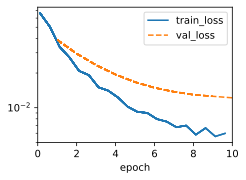

In [ ]:
train_scratch(5)

In [ ]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(),
                               lr=self.lr, weight_decay=self.wd)

L2 norm of w: 0.003220801241695881


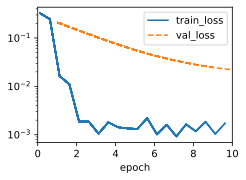

In [ ]:
model = WeightDecay(wd=5, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

In [ ]:
# close d21 module to allow for accuracy calculation 
@d2l.add_to_class(d2l.Module)
def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    #self.plot('loss', l, train=True)
    return l
@d2l.add_to_class(d2l.Module)
def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    #self.plot('loss', l, train=False)
    return l

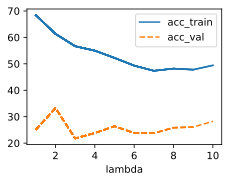

In [ ]:
import numpy as np

data = Data(num_train=100, num_val=100, num_inputs=200, batch_size=20)
trainer = d2l.Trainer(max_epochs=10)
test_epochs=np.arange(1,11,1)
board = d2l.ProgressBoard('lambda')

# define and calculate accuracy
def accuracy(y_hat, y):
    return (1 - ((y_hat - y).mean() / y.mean()).abs()) * 100
    
# define and save acc_train and acc_val variables
def train_ex1(lambd):    
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01) # learning rate set to 0.01
    model.board.yscale='log'
    trainer.fit(model, data)
    y_hat = model.forward(data.X)
    acc_train = accuracy(y_hat[:data.num_train], data.y[:data.num_train])
    acc_val = accuracy(y_hat[data.num_train:], data.y[data.num_train:])
    return acc_train, acc_val

data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# plot training and validation accuracy
for item in test_epochs:
    acc_train, acc_val = train_ex1(item)
    board.draw(item, acc_train.to(d2l.cpu()).detach().numpy(), 'acc_train', every_n=1)
    board.draw(item, acc_val.to(d2l.cpu()).detach().numpy(), 'acc_val', every_n=1)

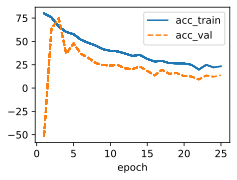

In [ ]:
import numpy as np

data = Data(num_train=100, num_val=100, num_inputs=200, batch_size=20)
trainer = d2l.Trainer(max_epochs=10)
test_epochs=np.arange(1,26,1)
board = d2l.ProgressBoard('epoch')

def accuracy(y_hat, y):
    return (1 - ((y_hat - y).mean() / y.mean()).abs()) * 100

def train_ex1(lambd):    
    model = WeightDecay(wd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    y_hat = model.forward(data.X)
    acc_train = accuracy(y_hat[:data.num_train], data.y[:data.num_train])
    acc_val = accuracy(y_hat[data.num_train:], data.y[data.num_train:])
    return acc_train, acc_val

for item in test_epochs:
    acc_train, acc_val = train_ex1(item)
    board.draw(item, acc_train.to(d2l.cpu()).detach().numpy(), 'acc_train', every_n=1)
    board.draw(item, acc_val.to(d2l.cpu()).detach().numpy(), 'acc_val', every_n=1)